In [1]:
import os
import cv2
import copy
import random
import struct
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from typing import Tuple
from datetime import datetime
from skimage.io import imread, imsave
from skimage.transform import resize
from scipy.stats import ttest_rel
from UNet.model import create_model
from UNet.metrics import overall_accuracy, precision, recall

plt.rcParams.update({'font.family': 'Times New Roman'})

# Load model and weights

In [2]:
model = create_model((384, 384), 4, 64)

2024-01-18 10:50:05.648887: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-18 10:50:05.649144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [3]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

In [4]:
MODEL_WEIGHTS = [
    'models/model_1/weights_model_1.hdf5',
    'models/model_2/weights_model_2.hdf5',
    'models/model_3/weights_model_3.hdf5'
]

# Baseline model test

For the validation validation, a separate validation set was selected randomly. It contains about 20% of all data

In [51]:
with open('validation/image_names_validation.csv', 'r') as f:
    validation_image_names = [x.strip() for x in f.readlines()[1:]]

validation_files = []
for validation_image_name in validation_image_names:
    img = imread(f'validation/input/{validation_image_name}.tif') / 255
    msk = imread(f'validation/gt/{validation_image_name}.tif') / 255
    validation_files.append([img.astype(np.float32), np.where(msk < 0.5, 0, 1).astype(np.float32)])

In [ ]:
with open('train/image_names_training.csv', 'r') as f:
    training_image_names = [x.strip() for x in f.readlines()[1:]]

training_files = []
for training_image_name in training_image_names:  ## TODO: Remove limit -- This is only because of RAM limitation
    img = imread(f'train/input/{training_image_name}.tif') / 255
    msk = imread(f'train/gt/{training_image_name}.tif') / 255
    training_files.append([img.astype(np.float32), np.where(msk < 0.5, 0, 1).astype(np.float32)])

In [6]:
with open('robustnesstest/image_names_robustness.csv', 'r') as f:
    robustness_image_names = [x.strip() for x in f.readlines()[1:]]

robustness_files = []
for robustness_image_name in robustness_image_names:
    img = imread(f'robustnesstest/input/{robustness_image_name}.tif') / 255
    msk = imread(f'robustnesstest/gt/{robustness_image_name}.tif') / 255
    robustness_files.append([img.astype(np.float32), np.where(msk < 0.5, 0, 1).astype(np.float32)])

In [88]:
def get_batch(data):
    n_batches = np.ceil(len(data) / 8)
    counter = 0
    while True:
        imgs = data[8 * counter:8 * (counter + 1)]
        yield (np.array([f[0] for f in imgs]), np.array([f[1] for f in imgs]))
        counter += 1
        if counter == n_batches:
            counter = 0

train_results = []
validation_results = []
robustness_results = []

for weights in MODEL_WEIGHTS:
    print("Starting with weights:", weights)
    model.load_weights(weights)

    # Evaluate on training data
    generator = get_batch(training_image_names)
    result = model.evaluate(generator, steps=int(np.ceil(len(training_image_names) / 8)))
    train_results.append([result[1], result[2], result[3]])

    # Evaluate on validation data
    generator = get_batch(validation_files)
    result = model.evaluate(generator, steps=int(np.ceil(len(validation_files) / 8)))
    validation_results.append([result[1], result[2], result[3]])

    # Evaluate on robustness data
    generator = get_batch(robustness_files)
    result = model.evaluate(generator, steps=int(np.ceil(len(robustness_files) / 8)))
    robustness_results.append([result[1], result[2], result[3]])

Starting with weights: models/model_1/weights_model_1.hdf5
2151/2151 [==============================] - 1451s 674ms/step - loss: 0.3022 - accuracy: 0.9012 - precision: 0.9286 - recall: 0.8289
Starting with weights: models/model_2/weights_model_2.hdf5
2151/2151 [==============================] - 1437s 668ms/step - loss: 0.3208 - accuracy: 0.8908 - precision: 0.8329 - recall: 0.9238
Starting with weights: models/model_3/weights_model_3.hdf5
2151/2151 [==============================] - 1443s 671ms/step - loss: 0.3408 - accuracy: 0.8808 - precision: 0.8148 - recall: 0.9265


In [53]:
validation_results

[[0.8991053700447083, 0.9252542853355408, 0.817609429359436],
 [0.8885493278503418, 0.8280596137046814, 0.915921151638031],
 [0.8780825734138489, 0.8097376227378845, 0.919858455657959]]

## Exemplary output

2024-01-18 10:50:25.280743: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-18 10:50:25.371563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


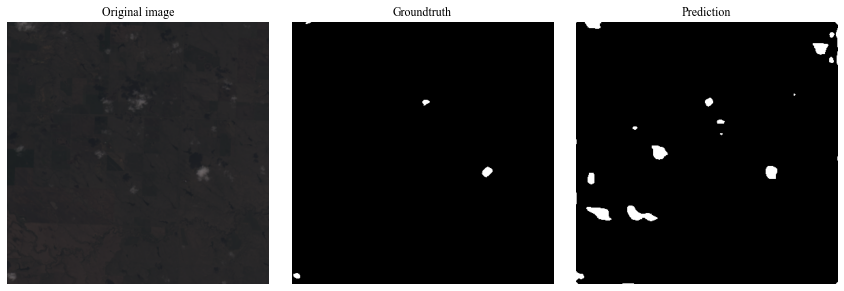

In [7]:
model.load_weights(MODEL_WEIGHTS[0])

img = robustness_files[27][0].astype(np.float32)
msk = robustness_files[27][1]
img = img.reshape((1, 384, 384, 4))
prediction = model.predict(img)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(img[0, :, :, :3])
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(msk, cmap='gray')
axes[1].set_title('Groundtruth')
axes[1].axis('off')

axes[2].imshow(np.where(prediction[0] < 0.5, 0, 1), cmap='gray')
axes[2].set_title('Prediction')
axes[2].axis('off')

plt.tight_layout()

plt.show()

# Apply filters to the images

## Hot Pixels

In [27]:
def get_hot_pixel_positions(image, n_pixels=30):
    positions = []
    for _ in range(n_pixels):
        x = int(np.random.uniform(0, image.shape[0] - 1))
        y = int(np.random.uniform(0, image.shape[1] - 1))
        positions.append([x, y])
    return positions
        
def apply_hot_pixels(images, positions):
    pixelated_images = copy.deepcopy(images)
    for x, y in positions:
        pixelated_images[:, x, y, :] = 1.
    return pixelated_images

In [38]:
results = open('experiment_results/hot_pixels.csv', 'w')
results.write('model,file,hotpixels,accuracy,precision,recall\n')

for weights in MODEL_WEIGHTS:
    print("[I] Start with weights:", weights)
    model.load_weights(weights)
    for i in range(50):
        positions = get_hot_pixel_positions(robustness_files[0][0], i)
        if len(positions) > 0:
            disturbed_img = apply_hot_pixels(copy.deepcopy(np.array([x[0] for x in robustness_files])), positions)
        else:
            disturbed_img = np.array([x[0] for x in robustness_files])

        predictions = []
        for j in range(5):
            p = model.predict(disturbed_img[j*10: j*10+10])
            predictions += list(p)
        
        for j, prediction in enumerate(predictions):
            mask = robustness_files[j][1]
            prec = precision(mask, prediction[:, :, 0])
            rec = recall(mask, prediction[:, :, 0])
            acc = overall_accuracy(mask, prediction[:, :, 0])
            if prec > 1 or rec > 1 or acc > 1:
                print("Values are wrong")
                print(prec, rec, acc)
                break

            results.write(f'{weights},{robustness_image_names[j]},{i},{acc},{prec},{rec}\n')
            
results.close()

[I] Start with weights: models/model_1/weights_model_1.hdf5
[I] Start with weights: models/model_2/weights_model_2.hdf5
[I] Start with weights: models/model_3/weights_model_3.hdf5


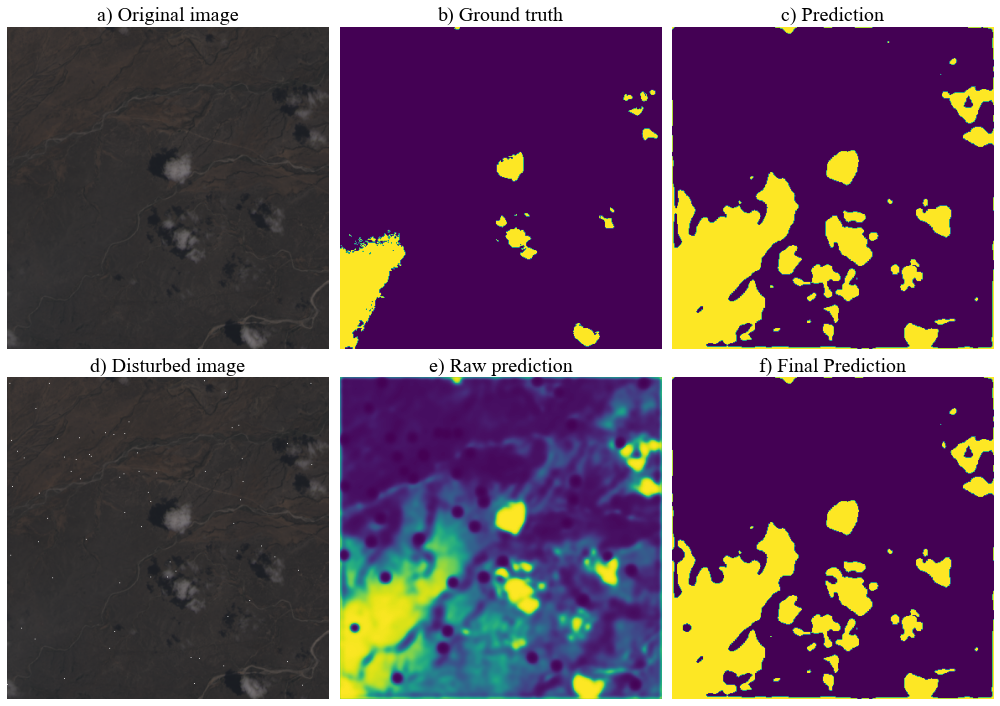

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(14, 10))

file_idx = 10

ax[0, 0].imshow(robustness_files[file_idx][0][:, :, :3])
ax[0, 0].set_title("a) Original image", size=20)
ax[0, 0].axis('off')

ax[0, 1].imshow(robustness_files[file_idx][1])
ax[0, 1].set_title('b) Ground truth', size=20)
ax[0, 1].axis('off')

p = model.predict(robustness_files[file_idx][0].reshape((1, 384, 384, 4)))

ax[0, 2].imshow(np.where(p[0] < 0.5, 0, 1))
ax[0, 2].set_title('c) Prediction', size=20)
ax[0, 2].axis('off')

# Apply hot pixels
hp = get_hot_pixel_positions(robustness_files[file_idx][0], 20)
disturbed_img = apply_hot_pixels(disturbed_img, hp)

ax[1, 0].imshow(disturbed_img[file_idx, :, :, :3])
ax[1, 0].set_title("d) Disturbed image", size=20)
ax[1, 0].axis('off')


ax[1, 1].imshow(predictions[file_idx])
ax[1, 1].set_title('e) Raw prediction', size=20)
ax[1, 1].axis('off')


ax[1, 2].imshow(np.where(predictions[file_idx] < 0.5, 0, 1))
ax[1, 2].set_title('f) Final Prediction', size=20)
ax[1, 2].axis('off')

plt.tight_layout()
plt.savefig('assets/hotpixel_influence.pdf', dpi=600)
plt.show()

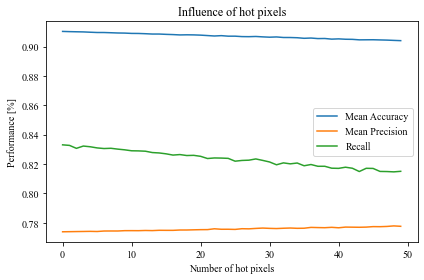

In [40]:
df = pd.read_csv("experiment_results/hot_pixels.csv", sep=",")
df = df[['hotpixels','accuracy','precision','recall']].groupby('hotpixels').mean().reset_index()

plt.figure()
plt.plot(df['accuracy'], label='Mean Accuracy')
plt.plot(df['precision'], label='Mean Precision')
plt.plot(df['recall'], label='Recall')
plt.title("Influence of hot pixels")
plt.xlabel("Number of hot pixels")
plt.ylabel("Performance [%]")
plt.legend()
plt.tight_layout()
plt.savefig('assets/hotpixels.pdf', dpi=600)
plt.show()

# Dark Current

In [41]:
def get_dark_current(shape, intensity):
    return np.random.uniform(0, 1, shape) * intensity

def apply_dark_current(images, dc):
    return np.clip(np.array(copy.deepcopy(images)) + dc, 0, 1)

In [42]:
results = open('experiment_results/dark_current.csv', 'w')
results.write('model,file,intensity,accuracy,precision,recall\n')

for weights in MODEL_WEIGHTS:
    print("[I] Start with weights:", weights)
    model.load_weights(weights)
    
    for i in range(20):
        dc = get_dark_current((384, 384, 4), i / 100)
        disturbed_img = apply_dark_current(np.array([x[0] for x in robustness_files]), dc)
        
        predictions = []
        for j in range(5):
            # print(disturbed_img[j*10: j*10+10].shape)
            p = model.predict(disturbed_img[j*10: j*10+10])
            predictions += list(p)
        
        for j, prediction in enumerate(predictions):
            mask = robustness_files[j][1]
            prec = precision(mask, prediction[:, :, 0])
            rec = recall(mask, prediction[:, :, 0])
            acc = overall_accuracy(mask, prediction[:, :, 0])
            if prec > 1 or rec > 1 or acc > 1:
                print("Values are wrong")
                print(prec, rec, acc)
                break
            
            results.write(f'{weights},{robustness_image_names[j]},{i / 100},{acc},{prec},{rec}\n')
            
results.close()

[I] Start with weights: models/model_1/weights_model_1.hdf5
[I] Start with weights: models/model_2/weights_model_2.hdf5
[I] Start with weights: models/model_3/weights_model_3.hdf5


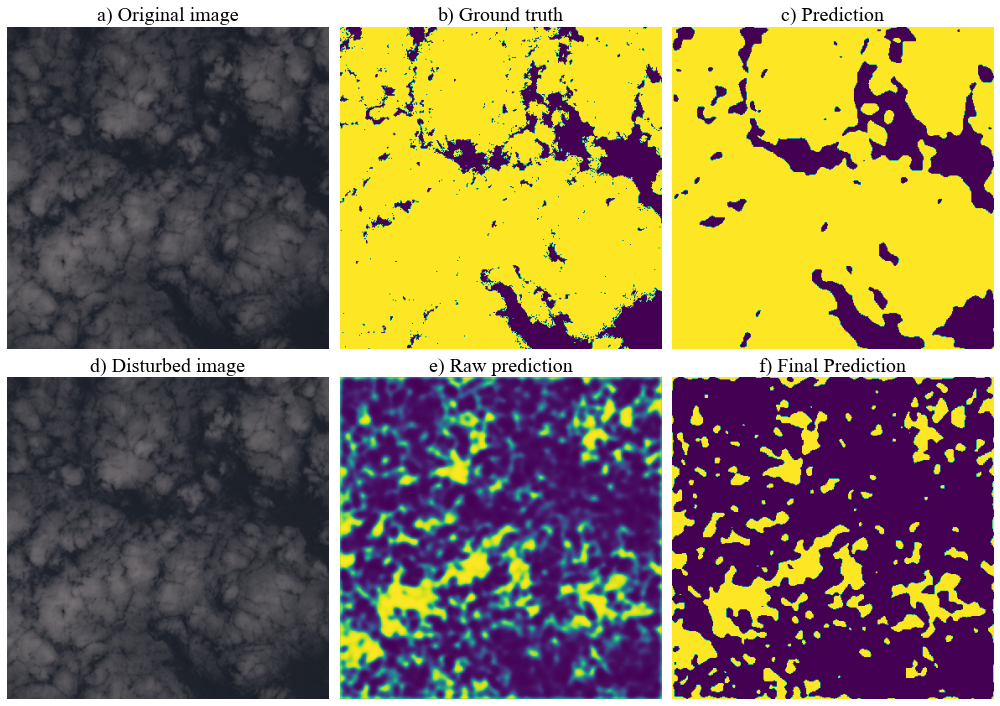

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(14, 10))

dc = get_dark_current((384, 384, 4), 0.02)
disturbed_img = apply_dark_current(np.array([x[0] for x in robustness_files]), dc)
    
file_idx = 7 # 6   22

ax[0, 0].imshow(robustness_files[file_idx][0][:, :, :3])
ax[0, 0].set_title("a) Original image", size=20)
ax[0, 0].axis('off')

ax[0, 1].imshow(robustness_files[file_idx][1])
ax[0, 1].set_title('b) Ground truth', size=20)
ax[0, 1].axis('off')

p = model.predict(robustness_files[file_idx][0].reshape((1, 384, 384, 4)))

ax[0, 2].imshow(np.where(p[0] < 0.5, 0, 1))
ax[0, 2].set_title('c) Prediction', size=20)
ax[0, 2].axis('off')


ax[1, 0].imshow(disturbed_img[file_idx, :, :, :3])
ax[1, 0].set_title("d) Disturbed image", size=20)
ax[1, 0].axis('off')


ax[1, 1].imshow(predictions[file_idx])
ax[1, 1].set_title('e) Raw prediction', size=20)
ax[1, 1].axis('off')


ax[1, 2].imshow(np.where(predictions[file_idx] < 0.5, 0, 1))
ax[1, 2].set_title('f) Final Prediction', size=20)
ax[1, 2].axis('off')

plt.tight_layout()
plt.savefig('assets/darkcurrent_influence.pdf', dpi=600)
plt.show()

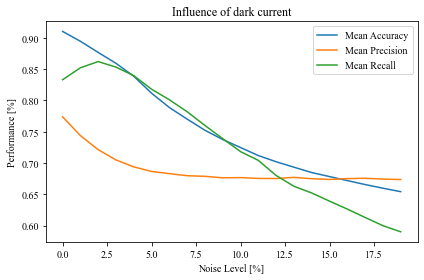

In [44]:
df = pd.read_csv("experiment_results/dark_current.csv", sep=",")
df = df[['intensity','accuracy','precision','recall']].groupby('intensity').mean().reset_index()

plt.figure()
plt.plot(df['accuracy'], label='Mean Accuracy')
plt.plot(df['precision'], label='Mean Precision')
plt.plot(df['recall'], label='Mean Recall')
plt.title("Influence of dark current")
plt.xlabel("Noise Level [%]")
plt.ylabel("Performance [%]")
plt.legend()
plt.tight_layout()
plt.savefig('assets/dark_current.pdf', dpi=600)
plt.show()

## Streaks in the image

In [50]:
def generate_streaks(shape, num_streaks, streak_length=30):
    streaks = []
    for _ in range(num_streaks):
        # Randomly generate streak properties
        streak_angle = np.random.uniform(0, 2*np.pi)  # Angle in radians
        streak_intensity = 1  # Intensity of the streak
        length = streak_length * np.random.rand()
        
        # Calculate the endpoints of the streak
        x1 = np.random.randint(0, shape[0])
        y1 = np.random.randint(0, shape[1])
        x2 = int(x1 + length * np.cos(streak_angle))
        y2 = int(y1 + length * np.sin(streak_angle))
        
        streaks.append([x1, y1, x2, y2, streak_intensity])
    return streaks

In [51]:
def apply_streaks(images, streaks):
    image_copy = copy.deepcopy(images)
    for i in range(image_copy.shape[0]):
        for streak in streaks:
            cv2.line(image_copy[i], (streak[0], streak[1]), (streak[2], streak[3]), (streak[4], streak[4], streak[4]), 1)
    return np.clip(image_copy, 0, 1)

In [47]:
results = open('experiment_results/streaks.csv', 'w')
results.write('model,file,nbstreaks,accuracy,precision,recall\n')

for weights in MODEL_WEIGHTS:
    print("[I] Start with weights:", weights)
    model.load_weights(weights)
    
    for i in range(30):
        s = generate_streaks((384, 384), i)
        disturbed_img = apply_streaks(np.array([f[0] for f in robustness_files]), s)
        
        predictions = []
        for j in range(5):
            p = model.predict(disturbed_img[j*10: j*10+10])
            predictions += list(p)
        
        for j, prediction in enumerate(predictions):
            mask = robustness_files[j][1]
            prec = precision(mask, prediction[:, :, 0])
            rec = recall(mask, prediction[:, :, 0])
            acc = overall_accuracy(mask, prediction[:, :, 0])
            if prec > 1 or rec > 1 or acc > 1:
                print("Values are wrong")
                print(prec, rec, acc)
                break
            
            results.write(f'{weights},{robustness_image_names[j]},{i},{acc},{prec},{rec}\n')
results.close()

[I] Start with weights: models/model_1/weights_model_1.hdf5
[I] Start with weights: models/model_2/weights_model_2.hdf5
[I] Start with weights: models/model_3/weights_model_3.hdf5


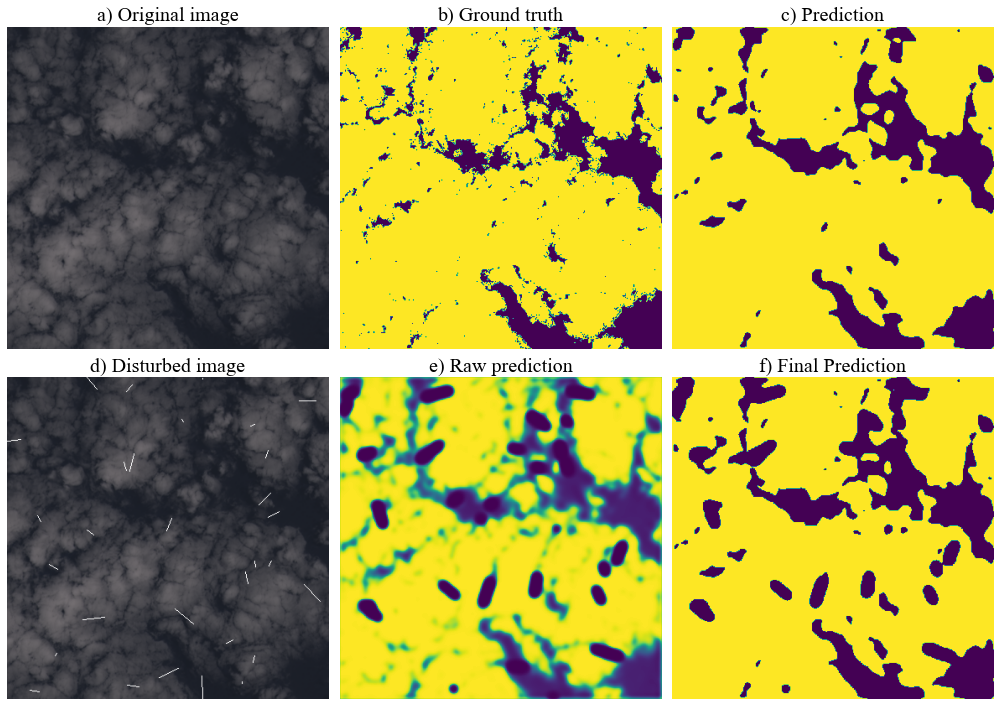

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(14, 10))

file_idx = 7 # 6   22

s = generate_streaks((384, 384), 30)
disturbed_img = apply_streaks(robustness_files[file_idx][0].reshape((1, 384, 384, 4)), s)

ax[0, 0].imshow(robustness_files[file_idx][0][:, :, :3])
ax[0, 0].set_title("a) Original image", size=20)
ax[0, 0].axis('off')

ax[0, 1].imshow(robustness_files[file_idx][1])
ax[0, 1].set_title('b) Ground truth', size=20)
ax[0, 1].axis('off')

p = model.predict(robustness_files[file_idx][0].reshape((1, 384, 384, 4)))

ax[0, 2].imshow(np.where(p[0] < 0.5, 0, 1))
ax[0, 2].set_title('c) Prediction', size=20)
ax[0, 2].axis('off')


ax[1, 0].imshow(disturbed_img[0, :, :, :3])
ax[1, 0].set_title("d) Disturbed image", size=20)
ax[1, 0].axis('off')


ax[1, 1].imshow(predictions[file_idx])
ax[1, 1].set_title('e) Raw prediction', size=20)
ax[1, 1].axis('off')


ax[1, 2].imshow(np.where(predictions[file_idx] < 0.5, 0, 1))
ax[1, 2].set_title('f) Final Prediction', size=20)
ax[1, 2].axis('off')

plt.tight_layout()
plt.savefig('assets/streaks_influence.pdf', dpi=600)
plt.show()

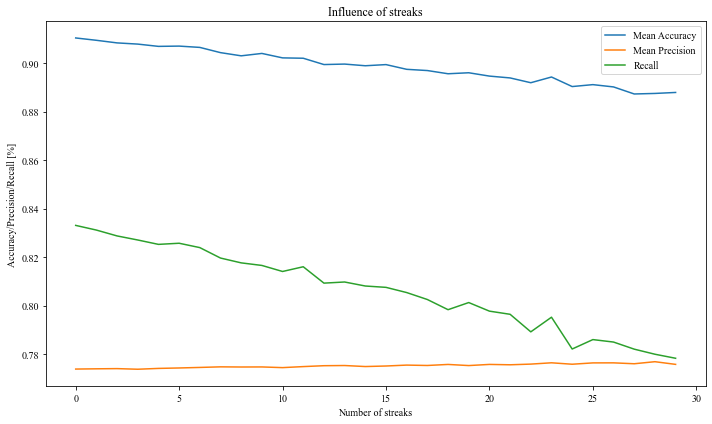

In [58]:
df = pd.read_csv("experiment_results/streaks.csv", sep=",")
df = df[['nbstreaks','accuracy','precision','recall']].groupby('nbstreaks').mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['accuracy'], label='Mean Accuracy')
plt.plot(df['precision'], label='Mean Precision')
plt.plot(df['recall'], label='Recall')
plt.title("Influence of streaks")
plt.xlabel("Number of streaks")
plt.ylabel("Accuracy/Precision/Recall [%]")
plt.legend()
plt.tight_layout()
plt.savefig("assets/streaks.pdf", dpi=600)
plt.show()

## Combined effects presented above

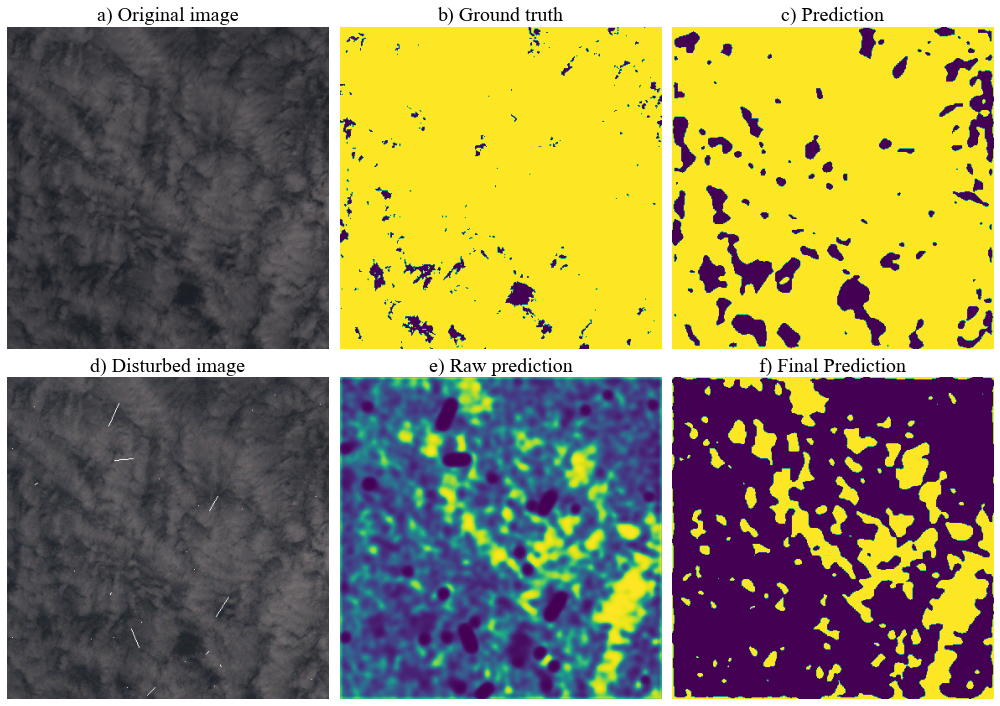

In [37]:
# Select the model
model.load_weights(MODEL_WEIGHTS[0])

# Select the file to inject
file_idx = 43

fig, ax = plt.subplots(2, 3, figsize=(14, 10))

disturbed_img = copy.deepcopy(robustness_files[file_idx][0]).reshape((1, 384, 384, 4))

# Apply hot pixels
hp = get_hot_pixel_positions(disturbed_img[0, :, :, 0], 20)
disturbed_img = apply_hot_pixels(disturbed_img, hp)

# Apply streaks in the image
st = generate_streaks((384, 384), 10)
disturbed_img = apply_streaks(disturbed_img, st)

# Apply dark current
dc = get_dark_current((384, 384, 4), 0.06)
disturbed_img = apply_dark_current(disturbed_img, dc)
disturbed_img = disturbed_img.reshape((1, 384, 384, 4))

predicted = model.predict(disturbed_img)

ax[0, 0].imshow(robustness_files[file_idx][0][:, :, :3])
ax[0, 0].set_title("a) Original image", size=20)
ax[0, 0].axis('off')

ax[0, 1].imshow(robustness_files[file_idx][1])
ax[0, 1].set_title('b) Ground truth', size=20)
ax[0, 1].axis('off')

p = model.predict(robustness_files[file_idx][0].reshape((1, 384, 384, 4)))

ax[0, 2].imshow(np.where(p[0] < 0.5, 0, 1))
ax[0, 2].set_title('c) Prediction', size=20)
ax[0, 2].axis('off')


ax[1, 0].imshow(disturbed_img[0, :, :, :3])
ax[1, 0].set_title("d) Disturbed image", size=20)
ax[1, 0].axis('off')


ax[1, 1].imshow(predicted[0])
ax[1, 1].set_title('e) Raw prediction', size=20)
ax[1, 1].axis('off')


ax[1, 2].imshow(np.where(predicted[0] < 0.5, 0, 1))
ax[1, 2].set_title('f) Final Prediction', size=20)
ax[1, 2].axis('off')

plt.tight_layout()
plt.savefig('assets/combined_influences.pdf', dpi=600)
plt.show()

## Create diagram that shows the influence of different factors

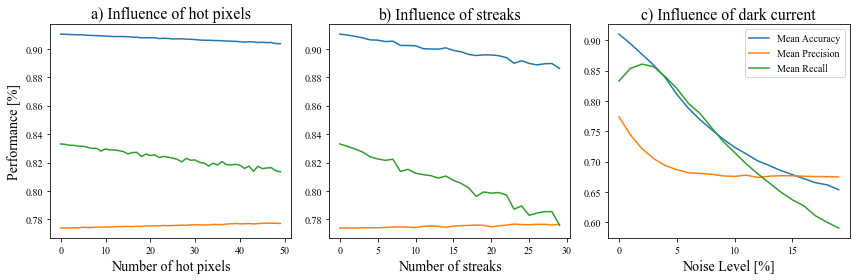

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

df = pd.read_csv("experiment_results/hot_pixels.csv", sep=",")
df = df[['hotpixels','accuracy','precision','recall']].groupby('hotpixels').mean().reset_index()

ax[0].plot(df['accuracy'], label='Mean Accuracy')
ax[0].plot(df['precision'], label='Mean Precision')
ax[0].plot(df['recall'], label='Recall')
ax[0].set_title("a) Influence of hot pixels", size=16)
ax[0].set_xlabel("Number of hot pixels", size=14)
ax[0].set_ylabel("Performance [%]", size=14)

df = pd.read_csv("experiment_results/streaks.csv", sep=",")
df = df[['nbstreaks','accuracy','precision','recall']].groupby('nbstreaks').mean().reset_index()

ax[1].plot(df['accuracy'], label='Mean Accuracy')
ax[1].plot(df['precision'], label='Mean Precision')
ax[1].plot(df['recall'], label='Recall')
ax[1].set_title("b) Influence of streaks", size=16)
ax[1].set_xlabel("Number of streaks", size=14)

df = pd.read_csv("experiment_results/dark_current.csv", sep=",")
df = df[['intensity','accuracy','precision','recall']].groupby('intensity').mean().reset_index()

ax[2].plot(df['accuracy'], label='Mean Accuracy')
ax[2].plot(df['precision'], label='Mean Precision')
ax[2].plot(df['recall'], label='Mean Recall')
ax[2].set_title("c) Influence of dark current", size=16)
ax[2].set_xlabel("Noise Level [%]", size=14)

plt.legend()
plt.tight_layout()
plt.savefig('assets/effects_on_images.pdf', dpi=600)
plt.show()

# Inject bitflips into Model Weights

- Randomly select weights of the model and inject bit-flips
- Do a layer by layer injection of bit-flips into the network
- Inject different amount of bit-flips

In [108]:
class BitFlipPosition:
    RANDOM = 0
    SIGN_BIT = 1
    EXPONENT_BIT = 2
    MANTISSA_BIT = 3

In [109]:
def perform_bitflip(value: np.float32, position: int = 0) -> Tuple[np.float32, int]:
    float_bytes = struct.pack('f', value)
    bits = list(bin(int.from_bytes(float_bytes, 'little'))[2:].zfill(32))

    flip_index: int = 0
    if position == BitFlipPosition.RANDOM:
        flip_index = random.randint(0, 31)

    elif position == BitFlipPosition.SIGN_BIT:
        flip_index = 0

    elif position == BitFlipPosition.EXPONENT_BIT:
        flip_index = random.randint(1, 8)
        
    elif position == BitFlipPosition.MANTISSA_BIT:
        flip_index = random.randint(9, 31)

    else:
        raise ValueError(f'Position {position} is no part of class BitFlipPosition')

    bits[flip_index] = '1' if bits[flip_index] == '0' else '0'
    return struct.unpack('f', int(''.join(bits), 2).to_bytes(4, 'little'))[0], flip_index

The following analysis is repeated many times. Due to the increased runtime, the analysis is performed on two types of images
- One image with some clouds
- One image with 100% clouds

In [116]:
file = open(f'experiment_results/bitflip-injection-{datetime.strftime(datetime.now(), format="%y-%m-%d-%H-%M")}.txt', 'w')
file.write('bitflip,model,layer,layerIdx,iteration,image,modifiedBit,valueBefore,valueAfter,accuracy,precision,recall\n')

for weights in MODEL_WEIGHTS:
    print("[I] Injection bit-flips in model", weights)
    model.load_weights(weights)
    weights_copy = copy.deepcopy(model.get_weights())

    # Iterate over the layers
    for i in [10, 11]:
        layer_name = model.trainable_variables[i].name

        for bft in [1, 2, 3]:

            # Repeat the experiment several times
            for j in tqdm(range(50)):

                # Copy the weights
                iteration_weights = copy.deepcopy(weights_copy)

                # Weight array of layer i can either be in the shape of (X, ) or (X, X, Y, Z, )
                if len(iteration_weights[i].shape) == 1:
                    flip_idx = random.randint(0, iteration_weights[i].shape[0] - 1)
                    value_before = iteration_weights[i][flip_idx]
                    value_after, modified_bit = perform_bitflip(value_before, bft)
                    iteration_weights[i][flip_idx] = value_after
                elif len(iteration_weights[i].shape) == 4:
                    shape = iteration_weights[i].shape
                    i1, i2, i3, i4 = (random.randint(0, shape[k] - 1) for k in range(4))
                    value_before = iteration_weights[i][i1, i2, i3, i4]
                    value_after, modified_bit = perform_bitflip(value_before, bft)
                    iteration_weights[i][i1, i2, i3, i4] = value_after
                else:
                    raise ValueError(f'Unexpected shape of the model found: {iteration_weights[i].shape}')

                model.set_weights(iteration_weights)

                predictions = []
                for k in range(5):
                    p = model.predict(np.array([x[0] for x in robustness_files[k*10:k*10+10]]))
                    predictions += list(p)

                for k, prediction in enumerate(predictions):
                    mask = robustness_files[k][1]
                    prec = precision(mask, prediction[:, :, 0])
                    rec = recall(mask, prediction[:, :, 0])
                    acc = overall_accuracy(mask, prediction[:, :, 0])

                file.write(f'{bft},{weights},{layer_name},{i},{j},{k},{modified_bit},{value_before},{value_after},{acc},{prec},{rec}\n')
file.close()
print("[!] Done")

[I] Injection bit-flips in model models/model_3/weights_model_3.hdf5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:21<00:00,  5.23s/it]

[!] Done
